In [327]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
import plotly.express as px
import plotly.io as pio
import seaborn as sns
from string import printable
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from statsmodels.formula.api import ols
from patsy import dmatrices
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns=100
pd.options.display.max_rows=100

In [328]:
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set(style="whitegrid")

Import Dataset

In [329]:
df = pd.read_csv('shelter_breed.csv')

In [330]:
df = df[['age_upon_outcome',
       'animal_id_outcome', 'date_of_birth', 'outcome_subtype', 'outcome_type',
       'sex_upon_outcome', 'age_upon_outcome_(days)',
       'age_upon_outcome_(years)', 'age_upon_outcome_age_group',
       'outcome_datetime', 'outcome_month', 'outcome_year',
       'outcome_monthyear', 'outcome_weekday', 'outcome_hour',
       'outcome_number', 'dob_year', 'dob_month', 'dob_monthyear',
       'age_upon_intake', 'animal_id_intake', 'animal_type', 'breed', 'color',
       'found_location', 'intake_condition', 'intake_type', 'sex_upon_intake',
       'count', 'age_upon_intake_days', 'age_upon_intake_tears',
       'age_upon_intake_age_group', 'intake_datetime', 'intake_month',
       'intake_year', 'intake_monthyear', 'intake_weekday', 'intake_hour',
       'intake_number', 'time_in_shelter', 'time_in_shelter_days', 'color1',
       'has_second_color', 'color2', 'is_dog', 'is_male', 'is_fixed',
       'found_city', 'found_lat', 'found_lon', 'region', 'breed1', 'is_breed2',
       'is_mix', 'breed2', 'max_weight', 'max_height', 'max_life']].reset_index()

Create Bins

In [331]:
df['outcome_datetime']=pd.to_datetime(df['outcome_datetime'])
df['intake_datetime']=pd.to_datetime(df['intake_datetime'])
df['intake_month']=df.intake_datetime.apply(lambda x: int(str(x)[5:7]))
df['intake_year']=df.intake_datetime.apply(lambda x: int(str(x)[:4]))
df['intake_weekday']=df.intake_datetime.dt.dayofweek

In [333]:
condition=[
    df['intake_condition'] == 'Aged',
    df['intake_condition'] == 'Ferral',
    df['intake_condition'] == 'Injured',
    df['intake_condition'] == 'Normal',
    df['intake_condition'] == 'Nursing',
    df['intake_condition'] == 'Other',
    df['intake_condition'] == 'Pregnant',
    df['intake_condition'] == 'Sick'
]
choices=[
    1,
    0,
    0,
    1,
    1,
    1,
    1,
    0
]
df['health']=np.select(condition,choices)

In [334]:
#Color bins
brown=['Brown Brindle','Red','Liver','Brown','Tan','Ruddy','Chocolate','Brown Tiger','Sable']
spotted=["Yellow Brindle",'Blue Merle','Black Tiger','Red Merle', 'Liver Tick','Agouti','Blue Tick','Black Brindle','Fawn','Brown Merle','Red Tick']
mustard=['Buff','Orange','Apricot']
other=['Tricolor','Pink','Blue']
white=['Silver','Cream','White']
black=['Black','Black Smoke','Gray','Blue Tiger']
gold=['Gold','Yellow', 'Blue Cream',]


In [335]:
conditions= [df.color1.isin(brown),
            df.color1.isin(spotted),
            df.color1.isin(mustard),
            df.color1.isin(other),
            df.color1.isin(white),
            df.color1.isin(black),
            df.color1.isin(gold)]
choices=['brown', 'spotted', 'mustard', 'other', 'white', 'black', 'gold']
df['color_bins'] = np.select(conditions, choices)

In [336]:
#Intake type bin
df['was_owned'] = np.where((df.intake_type=='Owner Surrender')|(df.intake_type=='Euthanasia Request'), 1, 0)

In [337]:
#breed size bin
conditions=[df.max_weight<12,
           df.max_weight<25,
           df.max_weight<50,
           df.max_weight<100]
choices=['toy', 'small','medium', 'large']
df['breed_cat']= np.select(conditions, choices, 'extra_large')

In [338]:
#age bin
conditions=[df.age_upon_intake_days<365,
           df.age_upon_intake_days>2555]
choices=['puppy', 'senior']
df['age_bin']= np.select(conditions, choices, 'average')

Interactions

In [341]:
df['bmi']=df.max_weight/(df.max_height)**2


Adding Pit Bull Feature

In [396]:
df['is_pitbull']= np.where((df.breed=='Pit Bull Mix')|(df.breed1=='Pit Bull')|(df.breed2=='Pit Bull'), 1, 0)

In [559]:
df['is_labrador']=np.where((df.breed=='Labrador Retriever Mix ')|(df.breed1=='Labrador Retriever')|(df.breed2=='Labrador Retriever'), 1, 0)

df['is_chihuahua']=np.where((df.breed=='Chihuahua Shorthair Mix ')|
                            (df.breed1=='Chihuahua Shorthair')|
                            (df.breed2=='Chihuahua Shorthair'), 1, 0)

Intake Season Bin

In [343]:
df['month']=df['intake_monthyear'].apply(lambda x: int(x[-2:]))
conditions=[(df.month <3)|(df.month==12),
           df.month<6,
           df.month<9]
cases=['winter', 'spring', 'summer']
df['season']=np.select(conditions, cases, 'fall')

In [345]:
df= pd.get_dummies(df, columns=['season'])

In [346]:
df = pd.get_dummies(df, columns=['age_bin'])

In [347]:
df = pd.get_dummies(df, columns=['intake_month', 'region', 'breed_cat', 'color_bins'])

Limiting Extreme Values

In [349]:
df= df[df.time_in_shelter_days<250]

Modeling

In [398]:
target = df['time_in_shelter_days']
features = df[['age_upon_intake_days', 'intake_year', 'intake_weekday', 'intake_hour', 'has_second_color', 'is_male', 'is_fixed','is_breed2', 'is_mix', 'max_weight',
       'max_height', 'max_life', 'health', 'was_owned', 'bmi', 'age_bin_puppy', 'age_bin_senior',
       'intake_month_2', 'intake_month_3', 'intake_month_4', 'intake_month_5',
       'intake_month_6', 'intake_month_7', 'intake_month_8', 'intake_month_9',
       'intake_month_10', 'intake_month_11', 'intake_month_12',
       'region_Austin', 'region_East', 'region_North', 'region_Northwest',
       'region_South', 'region_Travis',
       'breed_cat_extra_large', 'breed_cat_large', 'breed_cat_medium', 'breed_cat_toy', 'color_bins_black',
       'color_bins_brown', 'color_bins_gold', 'color_bins_mustard', 'color_bins_spotted', 'color_bins_white',  'season_winter',
       'season_spring', 'season_summer', 'is_pitbull','is_labrador',
       'is_chihuahua']]

In [399]:
featurelist='+'.join(features)

In [401]:
lr_model = ols(formula='time_in_shelter_days~'+featurelist, data=df).fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     time_in_shelter_days   R-squared:                       0.136
Model:                              OLS   Adj. R-squared:                  0.134
Method:                   Least Squares   F-statistic:                     63.97
Date:                  Sun, 13 Sep 2020   Prob (F-statistic):               0.00
Time:                          18:39:50   Log-Likelihood:                -98883.
No. Observations:                 20376   AIC:                         1.979e+05
Df Residuals:                     20325   BIC:                         1.983e+05
Df Model:                            50                                         
Covariance Type:              nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              4897.3744    351.281     13.941      0.000    4208.836    5585.913
age_upon_intake_days      0.0068      0.000     14.473      0.000       0.006       0.008
intake_year              -2.4206      0.174    -13.903      0.000      -2.762      -2.079
intake_weekday            0.1065      0.110      0.966      0.334      -0.110       0.322
intake_hour               0.0290      0.075      0.384      0.701      -0.119       0.177
has_second_color          1.3228      0.491      2.696      0.007       0.361       2.285
is_male                  -0.0969      0.438     -0.221      0.825      -0.955       0.762
is_fixed                  8.4654      1.351      6.266      0.000       5.817      11.113
is_breed2                -1.8874      0.755     -2.500      0.012      -3.367      -0.408
is_mix                    2.0698      1.026      2.017      0.044       0.059       4.081
max_weight               -0.0342      0.023     -1.473      0.141      -0.080       0.011
max_height               -0.2570      0.086     -2.995      0.003      -0.425      -0.089
max_life                 -0.8031      0.192     -4.185      0.000      -1.179      -0.427
health                  -23.9171      1.146    -20.879      0.000     -26.162     -21.672
was_owned                -0.6644      0.524     -1.267      0.205      -1.692       0.363
bmi                     -35.9360      6.082     -5.909      0.000     -47.857     -24.015
age_bin_puppy            -5.0040      0.576     -8.685      0.000      -6.133      -3.875
age_bin_senior           -4.8652      1.649     -2.950      0.003      -8.098      -1.632
intake_month_2           -0.7291      1.005     -0.726      0.468      -2.699       1.241
intake_month_3          -26.7256      9.981     -2.678      0.007     -46.290      -7.161
intake_month_4          -23.7655      9.988     -2.379      0.017     -43.343      -4.188
intake_month_5          -24.2544      9.973     -2.432      0.015     -43.803      -4.706
intake_month_6           77.5678     12.590      6.161      0.000      52.890     102.245
intake_month_7           76.9793     12.583      6.118      0.000      52.317     101.642
intake_month_8           76.0401     12.557      6.056      0.000      51.427     100.653
intake_month_9           15.9212      9.939      1.602      0.109      -3.559      35.402
intake_month_10          14.4559      9.944      1.454      0.146      -5.036      33.947
intake_month_11          13.7309      9.931      1.383      0.167      -5.735      33.197
intake_month_12          -1.6130      1.021     -1.579      0.114      -3.615       0.389
region_Austin             3.6825      1.688      2.182      0.029       0.374       6.991
region_East               4.0175      2.158      1.862      0.063      -0.212       8.247
r

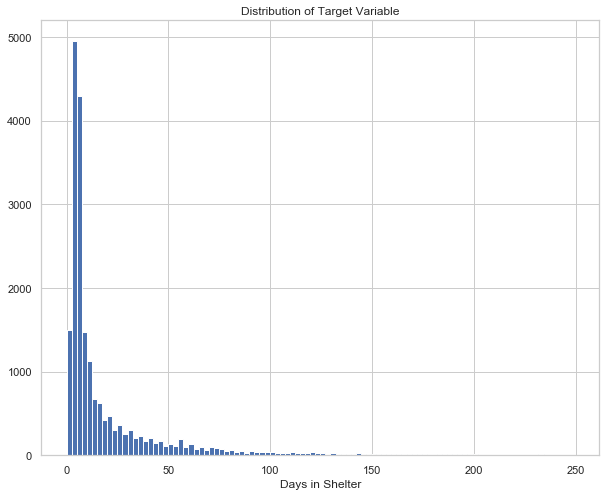

In [402]:
fig, ax = plt.subplots(figsize=(10,8))
ax.hist(target, bins=100)
ax.set_xlabel('Days in Shelter')
ax.set_title('Distribution of Target Variable')
fig.savefig('target_distribution.png')

Polynomial Interactions

In [500]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(features)
poly2_columns = poly_2.get_feature_names(features.columns)

df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
df_poly2.head()

,age_upon_intake_days,intake_year,intake_weekday,intake_hour,has_second_color,is_male,is_fixed,is_breed2,is_mix,max_weight,max_height,max_life,health,was_owned,bmi,age_bin_puppy,age_bin_senior,intake_month_2,intake_month_3,intake_month_4,intake_month_5,intake_month_6,intake_month_7,intake_month_8,intake_month_9,intake_month_10,intake_month_11,intake_month_12,region_Austin,region_East,region_North,region_Northwest,region_South,region_Travis,breed_cat_extra_large,breed_cat_large,breed_cat_medium,breed_cat_toy,color_bins_black,color_bins_brown,color_bins_gold,color_bins_mustard,color_bins_spotted,color_bins_white,season_winter,season_spring,season_summer,is_pitbull,is_labrador,is_chihuahua,...,color_bins_gold season_spring,color_bins_gold season_summer,color_bins_gold is_pitbull,color_bins_gold is_labrador,color_bins_gold is_chihuahua,color_bins_mustard^2,color_bins_mustard color_bins_spotted,color_bins_mustard color_bins_white,color_bins_mustard season_winter,color_bins_mustard season_spring,color_bins_mustard season_summer,color_bins_mustard is_pitbull,color_bins_mustard is_labrador,color_bins_mustard is_chihuahua,color_bins_spotted^2,color_bins_spotted color_bins_white,color_bins_spotted season_winter,color_bins_spotted season_spring,color_bins_spotted season_summer,color_bins_spotted is_pitbull,color_bins_spotted is_labrador,color_bins_spotted is_chihuahua,color_bins_white^2,color_bins_white season_winter,color_bins_white season_spring,color_bins_white season_summer,color_bins_white is_pitbull,color_bins_white is_labrador,color_bins_white is_chihuahua,season_winter^2,season_winter season_spring,season_winter season_summer,season_winter is_pitbull,season_winter is_labrador,season_winter is_chihuahua,season_spring^2,season_spring season_summer,season_spring is_pitbull,season_spring is_labrador,season_spring is_chihuahua,season_summer^2,season_summer is_pitbull,season_summer is_labrador,season_summer is_chihuahua,is_pitbull^2,is_pitbull is_labrador,is_pitbull is_chihuahua,is_labrador^2,is_labrador is_chihuahua,is_chihuahua^2
0,5840.0,2013.0,3.0,15.0,1.0,1.0,1.0,0.0,1.0,32.0,9.0,15.0,1.0,1.0,0.395062,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6205.0,2016.0,2.0,12.0,1.0,1.0,1.0,0.0,0.0,6.0,8.0,16.0,1.0,0.0,0.093750,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,5475.0,2015.0,1.0,12.0,1.0,1.0,1.0,1.0,1.0,57.5,19.5,14.5,1.0,0.0,0.151216,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,5475.0,2016.0,2.0,14.0,1.0,0.0,1.0,0.0,1.0,90.0,26.0,13.0,1.0,0.0,0.133136,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4015.0,2013.0,2.0,18.0,0.0,0.0,1.0,0.0,1.0,75.0,28.0,17.0,1.0,0.0,0.095663,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [504]:
X_train, X_test, y_train, y_test = train_test_split(df_poly2, target, random_state=9,test_size=0.2)
scaler2 = StandardScaler()

scaler2.fit(X_train)


X_train = pd.DataFrame(data=scaler2.transform(X_train), columns=df_poly2.columns)

X_test = pd.DataFrame(data=scaler2.transform(X_test), columns=df_poly2.columns)

In [505]:
lm_2 = LinearRegression()

#fit the linear regression to the data
lm_2 = lm_2.fit(X_train, y_train)

y_train_pred = lm_2.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))


print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 28.752645593563656


In [506]:
y_pred = lm_2.predict(X_test)

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Testing Root Mean Squared Error:' , test_rmse)


print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Testing Root Mean Squared Error: 89865981624.74724
Training:  28 vs. Testing:  89865981624


In [507]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

selector = SelectKBest(f_regression, k=28)

selector.fit(X_train, y_train)


SelectKBest(k=28, score_func=<function f_regression at 0x7f8265979dd0>)

In [508]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [509]:
list(selected_columns)

['age_upon_intake_days',
 'is_pitbull',
 'age_upon_intake_days intake_year',
 'age_upon_intake_days intake_hour',
 'age_upon_intake_days has_second_color',
 'age_upon_intake_days is_fixed',
 'age_upon_intake_days is_mix',
 'age_upon_intake_days max_weight',
 'age_upon_intake_days max_height',
 'age_upon_intake_days breed_cat_large',
 'age_upon_intake_days is_pitbull',
 'intake_year is_pitbull',
 'intake_weekday is_pitbull',
 'intake_hour is_pitbull',
 'has_second_color is_pitbull',
 'is_fixed breed_cat_large',
 'is_fixed is_pitbull',
 'is_mix is_pitbull',
 'max_weight is_pitbull',
 'max_height is_pitbull',
 'max_life breed_cat_large',
 'max_life is_pitbull',
 'health age_bin_puppy',
 'health is_pitbull',
 'bmi is_pitbull',
 'region_Austin is_pitbull',
 'breed_cat_large is_pitbull',
 'is_pitbull^2']

In [510]:
lm_k = LinearRegression()

#fit the linear regression to the data
lm_k = lm_2.fit(X_train[selected_columns], y_train)

y_train_pred = lm_2.predict(X_train[selected_columns])

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))


print('Training Root Mean Squared Error:' , train_rmse)

Training Root Mean Squared Error: 31.187300415349824


In [511]:
y_pred = lm_k.predict(X_test[selected_columns])

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Testing Root Mean Squared Error:' , test_rmse)


print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Testing Root Mean Squared Error: 31.195022210034516
Training:  31 vs. Testing:  31


In [512]:
lm_k.score(X_train[selected_columns], y_train)

0.1239013646666368

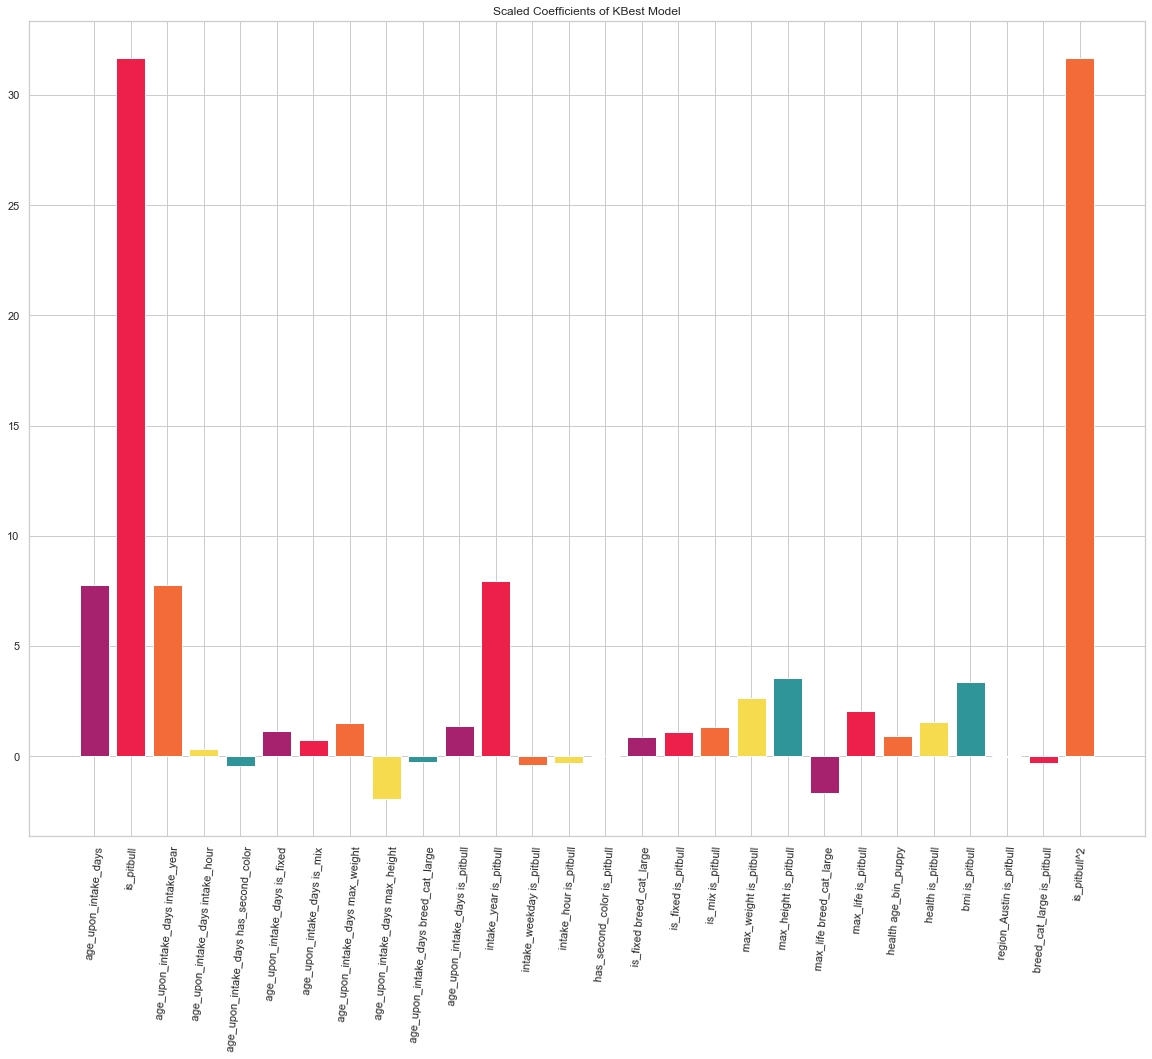

In [514]:
fig, ax = plt.subplots(figsize=(20,15))
ax.bar(selected_columns, [math.log(abs(x)) for x in lm_k.coef_], color=['#A7226E', '#EC2049', '#F26B38', '#F7DB4F', '#2F9599'])
ax.set_xticklabels(labels = selected_columns, rotation=85)
ax.set_title('Scaled Coefficients of KBest Model')
fig.savefig('pitbull_coefficients.png')

In [515]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.01, normalize=False)

lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)

train_rmse_lasso01 = metrics.mean_absolute_error(y_train, y_train_pred)
test_rmse_lasso01 = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse_lasso01) )
print('Testing Error: '+ str(test_rmse_lasso01) )



Training Error: 17.53852578058397
Testing Error: 30.99282393971124


In [519]:
target.quantile(.9)

56.521874999999994

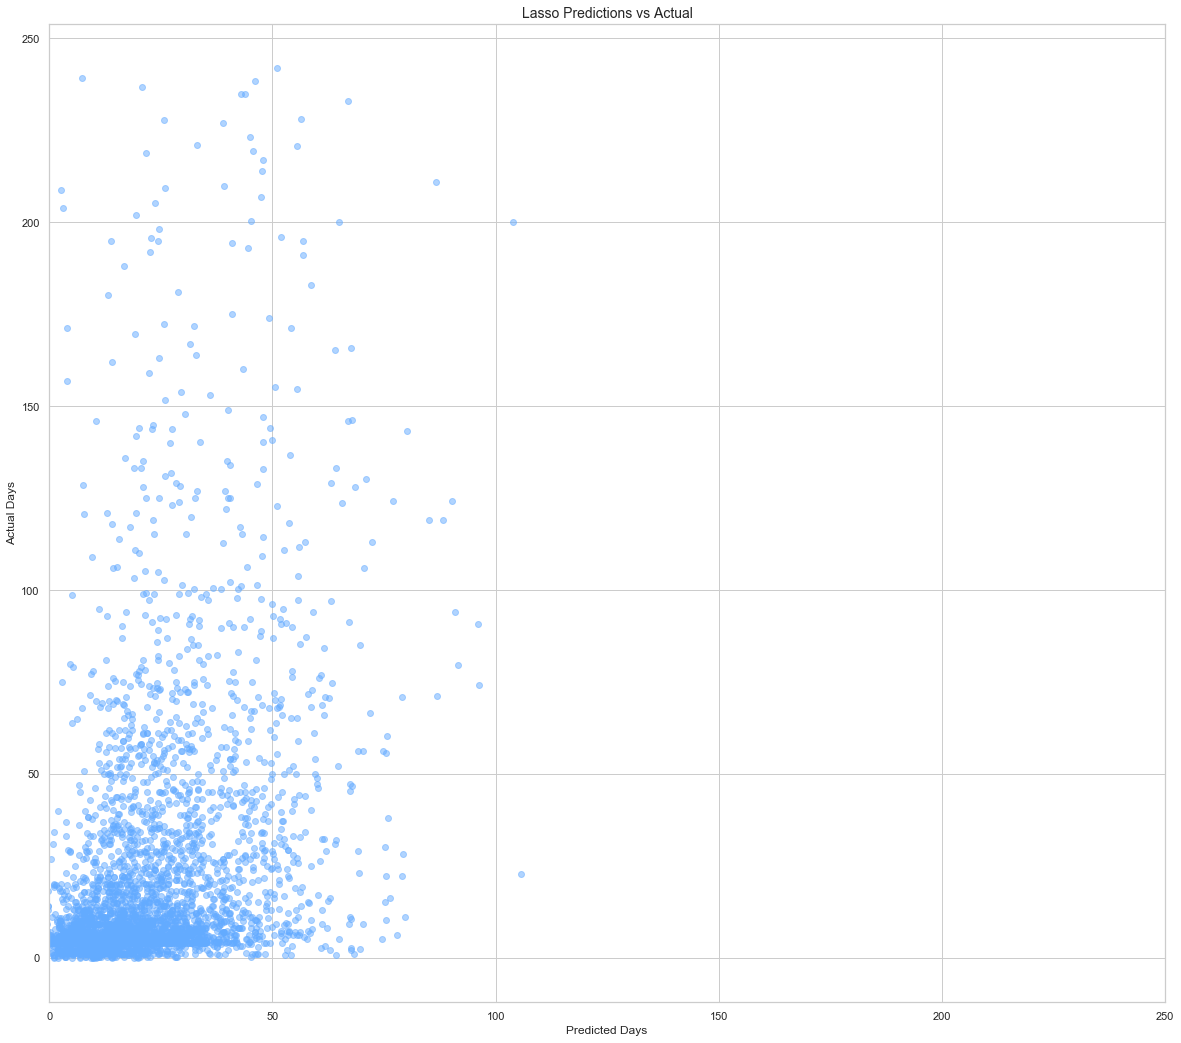

In [542]:
fig, ax= plt.subplots(figsize=(20, 18))
ax.scatter(y_pred, y_test, alpha=0.5, color='#63abff')
ax.set_xlim((0, 250))
ax.set_title('Lasso Predictions vs Actual', fontsize=14)
ax.set_xlabel('Predicted Days', fontsize=12)
ax.set_ylabel('Actual Days', fontsize=12)
fig.savefig('lassopredictions.png')


In [520]:
lasso_coef01 = pd.DataFrame(data=lasso.coef_).T
lasso_coef01.columns = X_train.columns
lasso_coef01 = lasso_coef01.T.sort_values(by=0).T

In [521]:
lasso.score(X_train, y_train)

0.2379608251620304

In [534]:
test.sort_values(by=0, ascending=False)

,0
1322,13.386701
59,5.724450
20,5.382956
679,4.875896
56,4.840751
...,...
383,-6.403002
465,-6.818230
692,-9.270696
1218,-9.759762


In [523]:
coeff_df = lasso_coef01.T

coeff_df[coeff_df[0]==0].count()

0    458
dtype: int64

In [424]:
len(coeff_df[coeff_df[0]!=0])

867

Poisson Distribution


In [545]:
mask = np.random.rand(len(df_poly2)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=16310
Testing data set length=4066


In [547]:
expr = 'time_in_shelter_days~'+featurelist

In [548]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [549]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [550]:
print(poisson_training_results.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     time_in_shelter_days   No. Observations:                16310
Model:                              GLM   Df Residuals:                    16259
Model Family:                   Poisson   Df Model:                           50
Link Function:                      log   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:            -2.3959e+05
Date:                  Sun, 13 Sep 2020   Deviance:                   4.1178e+05
Time:                          20:40:12   Pearson chi2:                 6.65e+05
No. Iterations:                       6                                         
Covariance Type:              nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept 

In [551]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

            mean   mean_se  mean_ci_lower  mean_ci_upper
0      47.513250  0.795808      45.978820      49.098889
2      72.889328  1.019849      70.917620      74.915855
6      44.929817  0.485287      43.988669      45.891102
13     56.584847  0.704652      55.220473      57.982932
16     33.207591  0.414464      32.405112      34.029943
...          ...       ...            ...            ...
20559  12.264881  0.123062      12.026040      12.508466
20562  12.115519  0.106319      11.908920      12.325703
20563  11.219687  0.101868      11.021795      11.421132
20574   5.714514  0.066066       5.586482       5.845480
20578  10.393279  0.123945      10.153169      10.639067

[4066 rows x 4 columns]


In [557]:
predictions_summary_frame[predictions_summary_frame.mean_ci_upper - predictions_summary_frame.mean_ci_lower>1]

,mean,mean_se,mean_ci_lower,mean_ci_upper
0,47.513250,0.795808,45.978820,49.098889
2,72.889328,1.019849,70.917620,74.915855
6,44.929817,0.485287,43.988669,45.891102
13,56.584847,0.704652,55.220473,57.982932
16,33.207591,0.414464,32.405112,34.029943
...,...,...,...,...
20368,20.497916,0.336784,19.848347,21.168744
20421,30.196125,0.279251,29.653734,30.748436
20439,19.851906,0.300685,19.271236,20.450072
20464,17.558575,0.396971,16.797512,18.354121


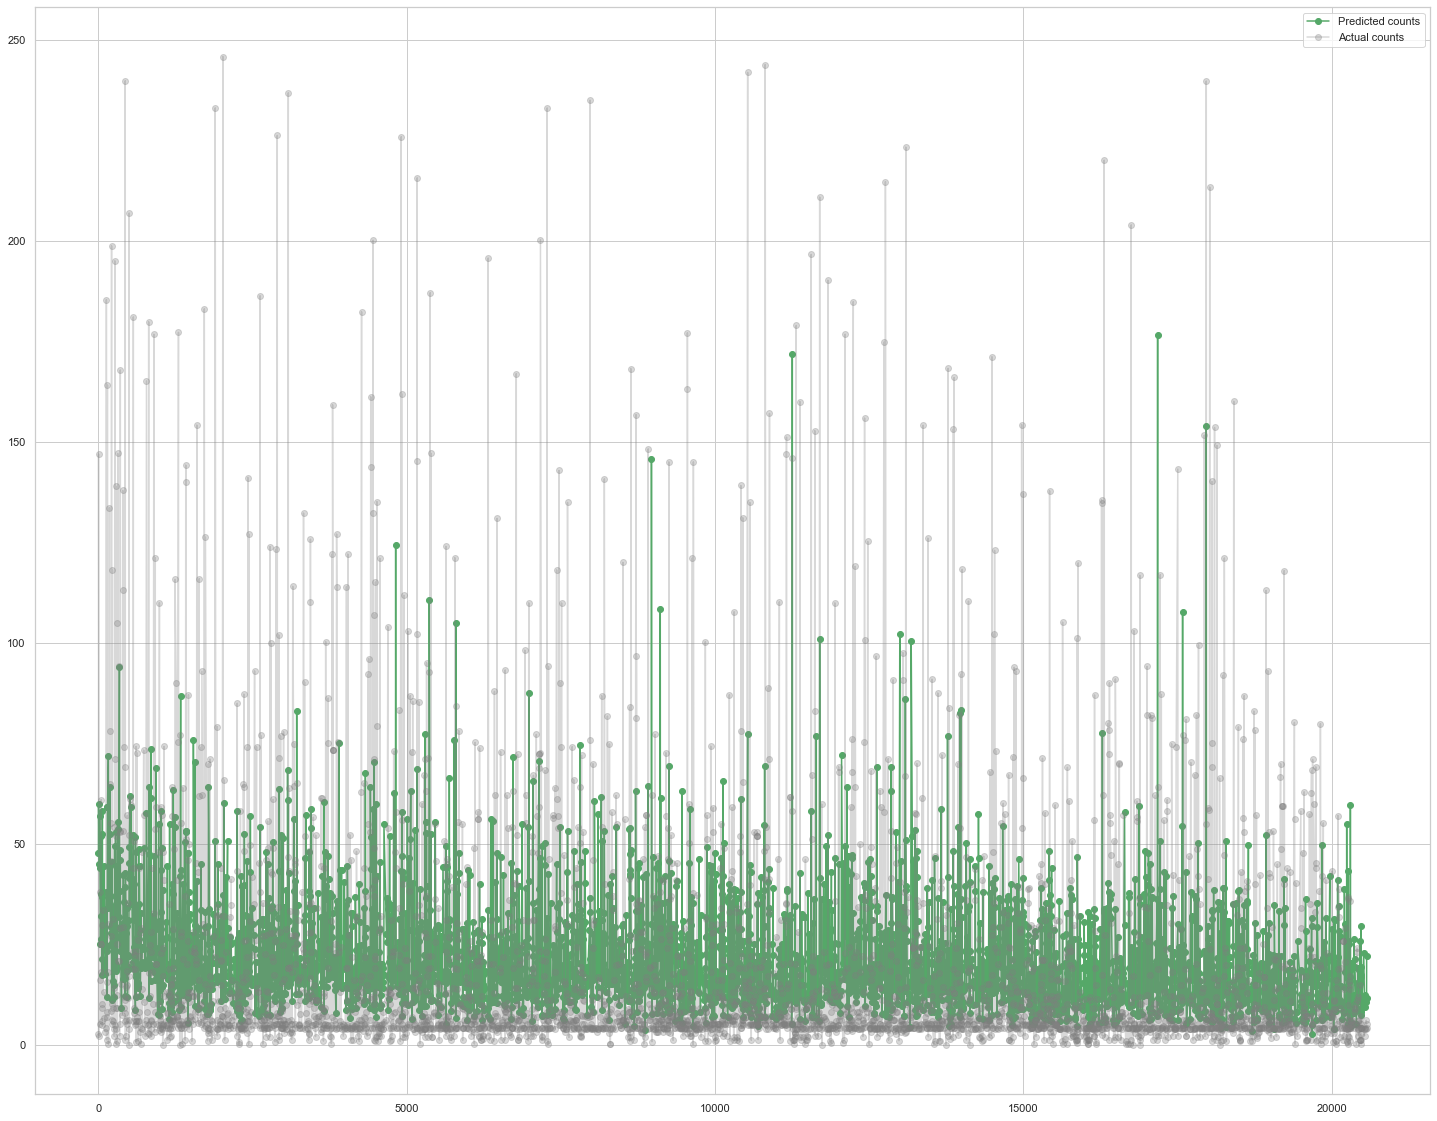

In [435]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['time_in_shelter_days']
fig = plt.figure(figsize=(25,20))
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts', color = 'grey', alpha=0.3)
plt.legend(handles=[predicted, actual])
plt.show()
fig.savefig('poisson_error250_pitbull.png')

In [434]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['time_in_shelter_days']
fig = plt.figure()
fig.suptitle('Predicted versus actual days')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')

In [286]:
df.groupby('annual_income').mental.var()

In [287]:
sum([df.groupby('breed').time_in_shelter_days.count()['Pit Bull Mix'], df.groupby('breed').time_in_shelter_days.count()['Labrador Retriever Mix'], df.groupby('breed').time_in_shelter_days.count()['Chihuahua Shorthair Mix']])

6868

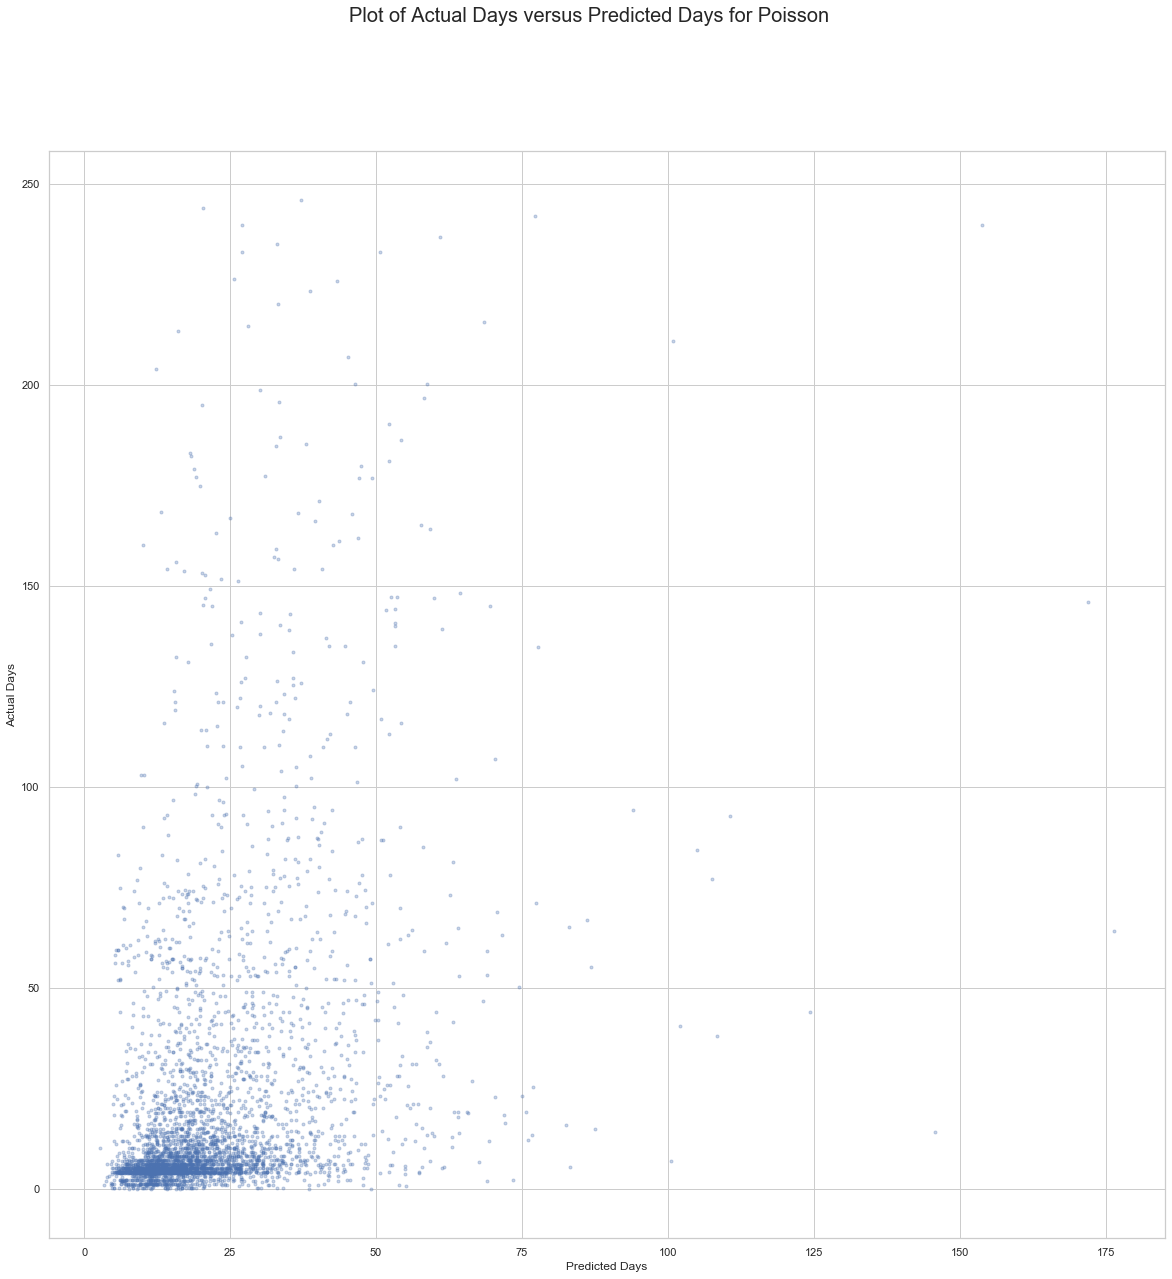

In [446]:
fig = plt.figure(figsize=(20,20))
fig.suptitle('Plot of Actual Days versus Predicted Days for Poisson', fontsize=20)
plt.scatter(x=predicted_counts, y=actual_counts, marker='.', alpha=0.3)
plt.xlabel('Predicted Days')
plt.ylabel('Actual Days')
plt.show()


In [288]:
#OneWay Anova for three breeds
#Ho: u1 = u2 = u3
#Ha: u1 ≠ u2 ≠ u3

k= 3
n_list = [df.groupby('breed').time_in_shelter_days.count()['Pit Bull Mix'], df.groupby('breed').time_in_shelter_days.count()['Labrador Retriever Mix'], df.groupby('breed').time_in_shelter_days.count()['Chihuahua Shorthair Mix']]
v_list = [df.groupby('breed').time_in_shelter_days.var()['Pit Bull Mix'], df.groupby('breed').time_in_shelter_days.var()['Labrador Retriever Mix'], df.groupby('breed').time_in_shelter_days.var()['Chihuahua Shorthair Mix']]
means = [df.groupby('breed').time_in_shelter_days.mean()['Pit Bull Mix'], df.groupby('breed').time_in_shelter_days.mean()['Labrador Retriever Mix'], df.groupby('breed').time_in_shelter_days.mean()['Chihuahua Shorthair Mix']]


ssb=sum([n*(df.time_in_shelter_days.mean() - mean)**2 for n, mean in zip(n_list, means)])
ssw=sum([(n-1)*v for n, v in zip(n_list,v_list)])
sst=sum([(mean-df.time_in_shelter_days.mean())**2 for mean in means])
dfb= k- 1
dfw= sum(n_list) - k 
dft= sum(n_list) - 1
msb = ssb/dfb
msw = ssw/dfw
mst = sst/(sum(n_list)-1)
print(msb/msw, dft)

358.5214938782432 6867


In [289]:
print(means)

[40.172940655447306, 21.223270239614394, 14.550455892479462]


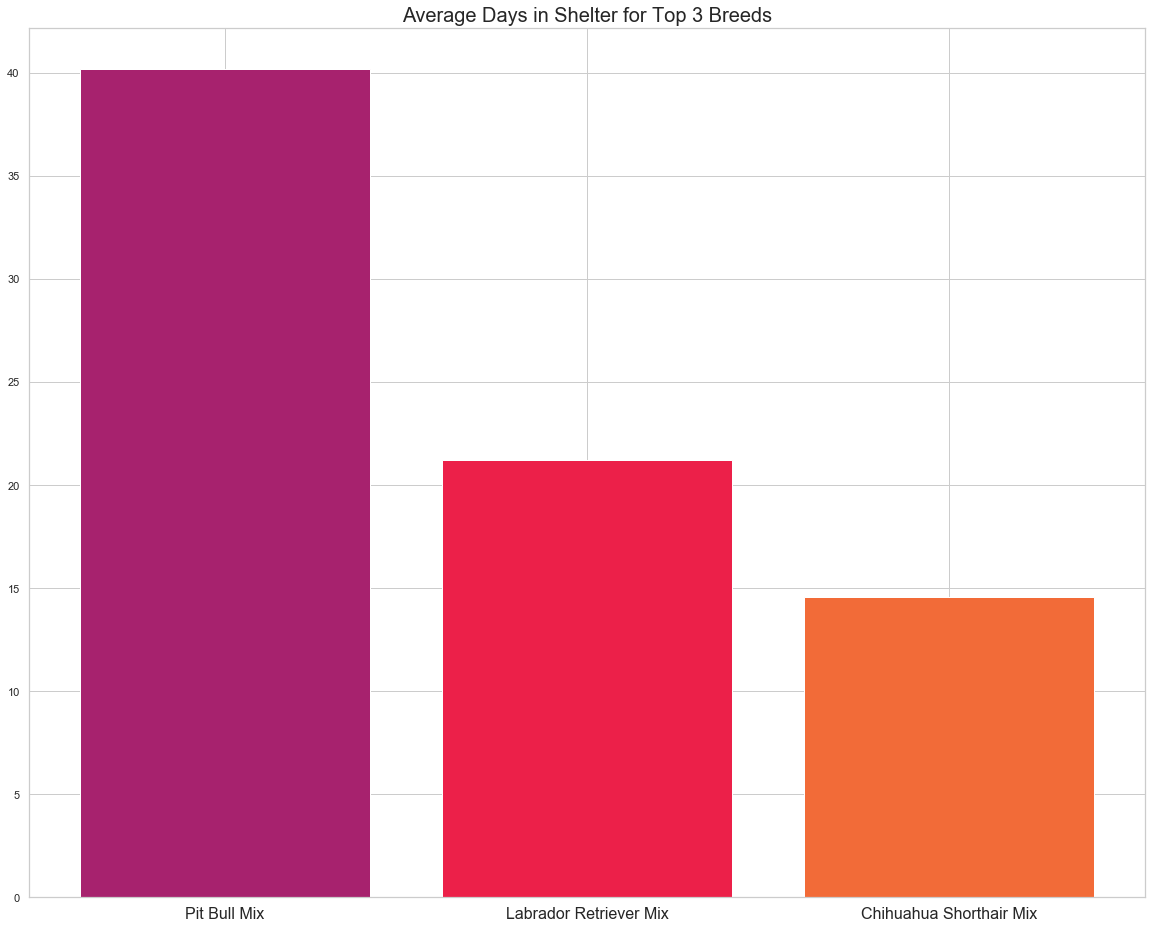

In [558]:
fig, ax=plt.subplots(figsize=(20,16))
ax.bar(['Pit Bull Mix', 'Labrador Retriever Mix', 'Chihuahua Shorthair Mix'],means, color=['#A7226E', '#EC2049', '#F26B38', '#F7DB4F', '#2F9599'])
ax.set_title('Average Days in Shelter for Top 3 Breeds', fontsize= 20)
ax.set_xticklabels(['Pit Bull Mix', 'Labrador Retriever Mix', 'Chihuahua Shorthair Mix'], fontsize= 16)
fig.savefig('average_days.png')